<h2><center>ASSIGNMENT 2</center></h2>
<h2><center>DEEP ASHISH JARIWALA, JAYDEEP SINGH</center></h2>
<h2><center>GROUP - 31</center></h2>
<h2><center>Q: CM5</center></h2>

## COVID DATASET-----NAIVE BAYES CLASSIFICATION ALGORITHM

#### IMPORTING THE LIBRARIES

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from mlxtend.plotting import plot_confusion_matrix

#### IMPORTING THE DATASET

In [3]:
dataset = pd.read_csv("covid_train.csv")
dataset.head(5)

,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
0,50s,MALE,NO KNOWN EPI LINK,Oakville,NaN,43.413997,-79.744796,Resolved
1,20s,FEMALE,CC,Guelph,NaN,43.524881,-80.233743,Not Resolved
2,90s,FEMALE,OB,Barrie,Yes,44.410713,-79.686306,Resolved
3,20s,FEMALE,MISSING INFORMATION,Toronto,NaN,43.656591,-79.379358,Resolved
4,90s,FEMALE,OB,Ottawa,Yes,45.345665,-75.763912,Fatal


#### EXPLORATORY DATA ANALYSIS

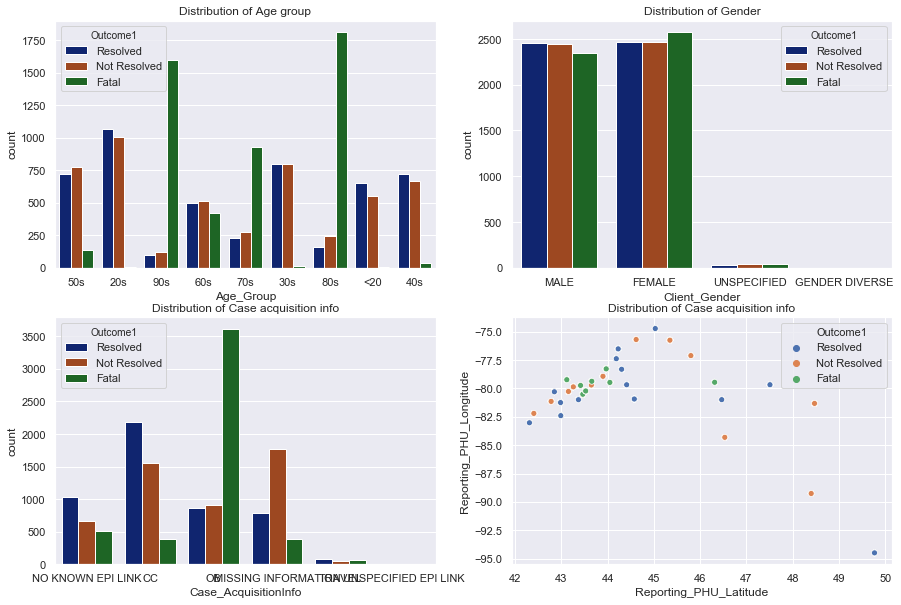

In [4]:
fig = plt.figure(figsize=(15,10))

plt.subplot(221)
plt.title("Distribution of Age group")
sns.countplot(x='Age_Group', hue='Outcome1', data = dataset, palette = 'dark')

plt.subplot(222)
plt.title("Distribution of Gender")
sns.countplot(x='Client_Gender', hue='Outcome1', data = dataset, palette = 'dark')

plt.subplot(223)
plt.title("Distribution of Case acquisition info")
sns.countplot(x='Case_AcquisitionInfo', hue='Outcome1', data = dataset, palette = 'dark')

plt.subplot(224)
plt.title("Distribution of Case acquisition info")
sns.scatterplot(x = 'Reporting_PHU_Latitude', y = 'Reporting_PHU_Longitude', hue = 'Outcome1', data = dataset)

<p>IMPORTANT FEATURES OBSERVED FROM THE PLOTS:</p>
<ul>
            <li>The age group of 70s, 80s and 90s has observed the highest fatal outcomes compared to other classes.</li>
            <li>There is particular pattern observed in the gender histogram plot. All the classes of outcomes are equally divided among males and females. The unspecified also has an almost equal distribution of target.</li>
            <li>The case aquisition info provides one interesting pattern, The Outbreak(OB) class in acquissition info has the highest fatal outcomes.</li>
            <li>An interesting pattern is observed in longitude v/s latitude plot, The box covered by latitude(43,44) and longitude(-77.5,-82.5) has the cases with most fatal outcomes. This region can be a red zone.</li>
</ul>

####  DATA CLEANING AND PREPROCESSING 

In [5]:
print(dataset.isna().sum())

# replacing NaN in Outbreak_Related with NO 
dataset['Outbreak_Related'] = dataset['Outbreak_Related'].fillna("No") 

# Dropping NaN values in Age_Group
dataset = dataset.dropna()

# Dropping unspecified gender values
dataset = dataset[dataset['Client_Gender'] != 'UNSPECIFIED']
dataset.head(5)

Age_Group                     6
Client_Gender                 0
Case_AcquisitionInfo          0
Reporting_PHU_City            0
Outbreak_Related           9020
Reporting_PHU_Latitude        0
Reporting_PHU_Longitude       0
Outcome1                      0
dtype: int64


,Age_Group,Client_Gender,Case_AcquisitionInfo,Reporting_PHU_City,Outbreak_Related,Reporting_PHU_Latitude,Reporting_PHU_Longitude,Outcome1
0,50s,MALE,NO KNOWN EPI LINK,Oakville,No,43.413997,-79.744796,Resolved
1,20s,FEMALE,CC,Guelph,No,43.524881,-80.233743,Not Resolved
2,90s,FEMALE,OB,Barrie,Yes,44.410713,-79.686306,Resolved
3,20s,FEMALE,MISSING INFORMATION,Toronto,No,43.656591,-79.379358,Resolved
4,90s,FEMALE,OB,Ottawa,Yes,45.345665,-75.763912,Fatal


In [6]:
dataset_features = dataset.iloc[:,:-1]
dataset_target = dataset.iloc[:, -1]

dataset_features['Age_Group'] = dataset_features['Age_Group'].replace({'<20': 1, '20s': 2, '30s': 3 , '40s': 4, '50s': 5, '60s': 6, '70s': 7, '80s': 8, '90s': 9})

categorical_cols = ['Client_Gender','Case_AcquisitionInfo','Reporting_PHU_City','Outbreak_Related']
# Create the encoder.
encoder = OneHotEncoder(categories = "auto", handle_unknown="error", sparse = False, drop= 'first')
# Fit and transform encoder to X
array_hot_encoded = encoder.fit_transform(dataset_features[categorical_cols])
# convert it to a Data Frame
data_hot_encoded = pd.DataFrame(array_hot_encoded, index=dataset_features.index)
# set column names of encoded dataframe
data_hot_encoded.columns = encoder.get_feature_names(categorical_cols)
# concatenate other columns with the encoded columns to get the final datset
data_other_cols = dataset_features.drop(columns=categorical_cols)
dataset_features = pd.concat([data_hot_encoded, data_other_cols], axis=1)

<p>The following steps are performed as a part of preprocessing the dataset into training set.</p>
<ul>
            <li>Imputation of NaN values in the Outbreak_related columns, all the NaNs are replaced with "No".</li>
            <li>All the values of unspecified gender are removed from the dataset, since the values were very less compared to the total length of the dataset.</li>
            <li>All the remaining NaN values were observed in Age_Group, which were dropped because only 6 values out of 14850 values were missing.</li>
            <li>Label encoding of Age_Group data as it is ordinal type of dataset. Moreover, the age wise ranking is also preserved in case of label encoding</li>
            <li>Other categorical features (Client_Gender, Case_AcquisitionInfo, Reporting_PHU_City, Outbreak_Related) were transformed using One-Hot Encoding for better results.</li>
</ul>

In [7]:
X, X_test, y, y_test = train_test_split(dataset_features, dataset_target, test_size = 0.15, random_state = 0)

<p> The dataset is splited into training and test using train_test_split method in sklearn. 85% dataset is used for training and then applied to grid search cv(using 10 fold cross validation) to tune the best parameters. The best tuned hyperparameters are used to train the model again and is tested on the 15% test set seperated to get the final accuracy. All the splits and algorithm used are applied with random_state = 0.</p>

#### TRAINING THE DATASET AND APPLYING GRID_SEARCH_CV METHOD 

In [8]:
nbclassifier = GaussianNB()
nbclassifier.fit(X, y)

var_before = nbclassifier.sigma_

cv = KFold(n_splits=10, random_state=0, shuffle=True)
parameters = [{'var_smoothing': [1e-10, 1e-9, 1e-5, 1e-3, 1e-1]}]
grid_search = GridSearchCV(estimator = nbclassifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = cv,
                           n_jobs = -1)
grid_search.fit(X, y)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
results = grid_search.cv_results_
print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 64.71 %
Best Parameters: {'var_smoothing': 0.1}


<p>The box above shows GRID_SEARCH_CV method to find the best hyperparameters. This method utilizes the concept of K-fold cross validation to evaluate the model on different hyperparamters. This case involves tuning of variable smoothing. The best parameter obtained for this case is: var_smoothing = 0.1. The box below shows all the results (for all the folds, mean accuracy, ranked test score among all the splits and computation time for grid search hyperparameter tuning).</p>

In [9]:
results

{'mean_fit_time': array([0.07613966, 0.07030253, 0.06828876, 0.06979206, 0.06231432]),
 'std_fit_time': array([0.0058271 , 0.0075002 , 0.00453775, 0.00929341, 0.00808959]),
 'mean_score_time': array([0.00974283, 0.00831242, 0.01091747, 0.0125473 , 0.00641344]),
 'std_score_time': array([0.00210948, 0.00154924, 0.0030983 , 0.00824613, 0.00277547]),
 'param_var_smoothing': masked_array(data=[1e-10, 1e-09, 1e-05, 0.001, 0.1],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'var_smoothing': 1e-10},
  {'var_smoothing': 1e-09},
  {'var_smoothing': 1e-05},
  {'var_smoothing': 0.001},
  {'var_smoothing': 0.1}],
 'split0_test_score': array([0.52753392, 0.52913009, 0.53950519, 0.57462091, 0.63607342]),
 'split1_test_score': array([0.44293695, 0.45889864, 0.52753392, 0.60335196, 0.6528332 ]),
 'split2_test_score': array([0.47964884, 0.49082203, 0.55786113, 0.64006385, 0.67278532]),
 'split3_test_score': array([0.45490822, 0.

Text(0.5, 1.0, 'Graph of mean accuracy v/s variable smoothing')

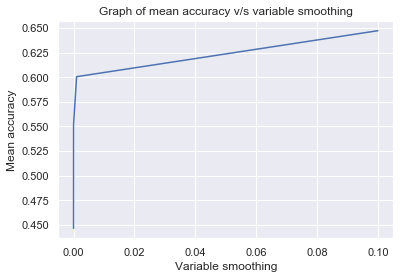

In [10]:
mean_accuracy = grid_search.cv_results_['mean_test_score']
varsm = [1e-10, 1e-9, 1e-5, 1e-3, 1e-1]

sns.lineplot(varsm, mean_accuracy)
plt.xlabel("Variable smoothing")
plt.ylabel("Mean accuracy")
plt.title("Graph of mean accuracy v/s variable smoothing")

<p>The graph above shows the variation of mean validation accuracy with change in var_smoothing parameter. The best accuracy is observed at var_smoothing = 0.1.</p>

#### TEST SET ACCURACY

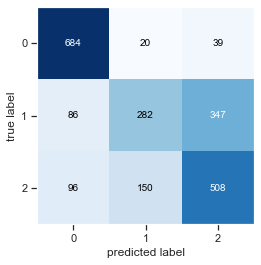

The accuracy obtained on test set with best tuned hyperparameters: 66.6365280289331 % 


In [11]:
nbclassifier_final = GaussianNB(var_smoothing = 0.1)
nbclassifier_final.fit(X, y)

var_after = nbclassifier_final.sigma_

y_pred = nbclassifier_final.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()
ac = accuracy_score(y_test, y_pred)
print(f"The accuracy obtained on test set with best tuned hyperparameters: {ac*100} % ")

#### Parameters learned by the NB Classifier: (to be used in CM6 analysis)

In [12]:
# number of training samples observed in each class.
print(f"nbclassifier_final.class_count_: {nbclassifier_final.class_count_}\n")


# probability of each class.
print(f"nbclassifier_final.class_prior_: {nbclassifier_final.class_prior_}\n")


# class labels known to the classifier
print(f"nbclassifier_final.classes_: {nbclassifier_final.classes_}\n")


# mean of each feature per class
print(f"nbclassifier_final.theta_: {nbclassifier_final.theta_}\n")


# variance of each feature per class
print(f"nbclassifier_final.sigma_: {nbclassifier_final.sigma_}\n")


# absolute additive value to variances
print(f"nbclassifier_final.epsilon_: {nbclassifier_final.epsilon_}\n")

nbclassifier_final.class_count_: [4172. 4191. 4166.]

nbclassifier_final.class_prior_: [0.33298747 0.33450395 0.33250858]

nbclassifier_final.classes_: ['Fatal' 'Not Resolved' 'Resolved']

nbclassifier_final.theta_: [[ 0.00000000e+00  4.79386385e-01  7.83796740e-02  1.03547459e-01
   7.27468840e-01  1.27037392e-02  0.00000000e+00  7.19079578e-04
   1.43815916e-03  8.38926174e-03  4.79386385e-04  9.58772771e-03
   1.17449664e-02  4.07478428e-02  0.00000000e+00  2.39693193e-04
   2.80441035e-02  9.58772771e-02  2.39693193e-04  7.67018217e-02
   2.39693193e-04  2.56471716e-02  6.78331735e-02  0.00000000e+00
   2.39693193e-04  1.19846596e-03  5.51294343e-03  6.23202301e-03
   2.39693193e-04  6.23202301e-03  9.82742090e-03  6.23202301e-03
   7.19079578e-04  5.12943432e-02  3.83509108e-03  1.91754554e-03
   3.83748802e-01  3.40364334e-02  4.81783317e-02  4.88974113e-02
   7.56951103e-01  7.82790029e+00  4.37228728e+01 -7.94726359e+01]
 [ 0.00000000e+00  4.94392746e-01  3.55762348e-01  1.3218

#### TABLE TO SHOW THE CHANGE IN VARIANCE AFFECTED BY VAR_SMOOTHING

In [13]:
var = var_after - var_before
df = pd.DataFrame(var, index = ['class 1','class 2','class 3'], columns = dataset_features.columns)
print(df)

         Client_Gender_GENDER DIVERSE  Client_Gender_MALE  \
class 1                      0.682745            0.682745   
class 2                      0.682745            0.682745   
class 3                      0.682745            0.682745   

         Case_AcquisitionInfo_MISSING INFORMATION  \
class 1                                  0.682745   
class 2                                  0.682745   
class 3                                  0.682745   

         Case_AcquisitionInfo_NO KNOWN EPI LINK  Case_AcquisitionInfo_OB  \
class 1                                0.682745                 0.682745   
class 2                                0.682745                 0.682745   
class 3                                0.682745                 0.682745   

         Case_AcquisitionInfo_TRAVEL  \
class 1                     0.682745   
class 2                     0.682745   
class 3                     0.682745   

         Case_AcquisitionInfo_UNSPECIFIED EPI LINK  \
class 1               

<p>The above table shows the change in variance for all the features and classes with the change in var_smoothing paramter from 1e-9 to 0.001. We can see a change of 0.682745 in all the features, which indicates the stabilzation provided in calculation of prior probabilities. Moreover, it increases the variance to make it a better estimator.</p>
<p>The var_smoothing parameter provides the portion of the largest variance of the features, that can be added based on the value in order to stabilize calculation linked with prior probabilities. This essentially widens (or "smooths") the curve and accounts for more samples that are further away from the distribution mean. Moreover, higher the variance between two features the less correlational and better estimator since Naive Bayes assumes that samples are i.i.d.</p> 

<h2>References</h2>

<a>https://scikit-learn.org/stable/modules/naive_bayes.html</a>

<a>https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB</a>

<a>https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html</a>

<a>https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html</a>

<a>http://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix/</a>

<a>https://stackoverflow.com/questions/58046129/can-someone-give-a-good-math-stats-explanation-as-to-what-the-parameter-var-smoo</a>

<a>http://seaborn.pydata.org/</a>

<a>https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html</a>

<a>https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html</a>

<a>https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html</a>